In [1]:
import numpy as np
import pandas as pd
import gym
from datetime import datetime, timedelta
import matplotlib.pyplot as plt

daily_prices = pd.read_csv('../data/dfs/daily/price.csv', index_col=0)
daily_prices['Dates'] = pd.to_datetime(daily_prices['Dates'])
daily_prices = daily_prices.set_index('Dates')

In [2]:
train_val_splits = []
block = np.array([2000,2002,2002,2003])
for i in range(7):
    train_val_splits.append(block+[3*i,3*i,3*i,3*i])
#train_val_splits = [[2014,2018,2018,2020]]
print(train_val_splits)

[array([2000, 2002, 2002, 2003]), array([2003, 2005, 2005, 2006]), array([2006, 2008, 2008, 2009]), array([2009, 2011, 2011, 2012]), array([2012, 2014, 2014, 2015]), array([2015, 2017, 2017, 2018]), array([2018, 2020, 2020, 2021])]


In [3]:
prediction_df = pd.DataFrame()
for stock in daily_prices.columns:
    stock_df = pd.read_csv("../directions/attention/Directions " + stock + ".csv")
    prediction_df[stock] = np.mean(stock_df.to_numpy()[:,-10:] == 1, axis=-1)
    
    if stock == "AMM":
        prediction_df['Dates'] = pd.to_datetime(stock_df['Dates'])
        
daily_prices = daily_prices.loc[prediction_df['Dates']]
prediction_df = prediction_df.set_index('Dates')

In [4]:
state_dict = {}
for i in daily_prices.columns:
    tmpdf = pd.read_csv('../data/Day Data with Volatility/{} MK Equity.csv'.format(i))
    tmpdf.Dates = pd.to_datetime(tmpdf.Dates)
    tmpdf = tmpdf.set_index('Dates')
    state_dict[i]=tmpdf

In [5]:
class DayEnv(gym.Env):
    
    def __init__(self, prices_df, timeframe, starting_balance=1000000, pfstate=False):
        super(DayEnv, self).__init__()
        self.prices = prices_df[f'{timeframe[0]}-1-1':f'{timeframe[1]}-1-1']
        self.dates = self.prices.index
        self.num_timesteps = len(self.dates)
        self.symbols = self.prices.columns
        self.action_space = gym.spaces.MultiDiscrete(tuple([3]*len(self.symbols)))
        self.portfolio_in_state = pfstate
        if self.portfolio_in_state:
            self.observation_space = gym.spaces.Box(-1,1, shape=(2, len(self.symbols)))
        else:
            self.observation_space = gym.spaces.Box(-1,1, shape=(len(self.symbols),))
        self.starting_balance = starting_balance
        self.curr_portfolio = np.zeros(len(self.symbols))
        self.transaction_cost = 0.025

        
    def step(self, action: np.ndarray):
        assert len(action) == len(self.symbols)
        
        sell_mask = np.logical_and((action == 0), self.curr_portfolio > 0)
        #hold_mask = (action == 1)
        buy_mask = (action == 2)
        
        curr_prices = self.prices.iloc[self.curr_idx].values
        next_prices = self.prices.iloc[self.curr_idx + 1].values
        
        # First sell stocks
        realized_profits = np.dot(curr_prices[sell_mask], self.curr_portfolio[sell_mask]) * (1-self.transaction_cost)

        # Add realized profit to cash balance
        self.cash_balance += realized_profits
        self.curr_portfolio[sell_mask] = 0
        
        # Then buy stocks evenly with remaining balance
        weights = np.zeros(action.shape)
        weights[buy_mask] = action[buy_mask] / np.sum(action[buy_mask])
        
        new_shares = np.floor(self.cash_balance * weights / (curr_prices*(1+self.transaction_cost)))
        shares_cost = np.dot(curr_prices, new_shares) * (1+self.transaction_cost)
        self.curr_portfolio += new_shares
        self.cash_balance -= shares_cost
        self.curr_balance = self.cash_balance + np.dot(self.curr_portfolio, next_prices)
        
#         unrealized_profits = np.dot(next_prices - curr_prices, self.curr_portfolio)
#         print('unrealized',unrealized_profits)
        # np.sum(np.dot(curr_prices, np.abs(shares - self.curr_portfolio)))*self.transaction_cost
        
        profits = self.curr_balance - self.last_balance
#         print(action)
        reward = self._calc_reward(profits)
        self.last_balance = self.curr_balance
        
#         self.curr_balance += profits
        self.history.append(self.curr_balance)
        self.curr_idx += 1
        
        done=False
        if self.curr_idx == self.num_timesteps-1 or self.curr_balance <= 0:
            done = True
        return self._get_obs(), reward, done, {}

    
    def reset(self):
        self.curr_idx = 0
        self.cash_balance = self.starting_balance
        self.curr_balance = self.starting_balance
        self.last_balance = self.curr_balance
        self.history = [self.curr_balance]
        self.curr_portfolio = np.zeros(len(self.symbols))
        return self._get_obs()

    
    def _calc_reward(self, profit):
        return profit/self.curr_balance

    def _get_obs(self):
        if self.curr_idx == self.num_timesteps-1 or self.curr_balance <= 0:
            oracle=np.zeros(self.observation_space.shape)
        else:
            oracle = prediction_df.loc[self.dates[self.curr_idx]].to_numpy()
            
        fractional = self.curr_portfolio * self.prices.iloc[self.curr_idx].values /self.curr_balance
        if self.portfolio_in_state:
            return np.vstack([oracle, fractional])
        else:
            return oracle


In [6]:
test = DayEnv(daily_prices, train_val_splits[0][:2])
test.reset()
print(test.step(np.array([0,1,2,0,1,2,0,1,2,0,1,2,0,1,2,0,1,2,0,1])))
test.step(np.array([0,0,2,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0]))
test.step(np.array([0,0,1,0,0,0,0,0,0,2,2,0,0,0,0,0,0,0,0,0]))

654130.1358899999

(array([0.1, 0.2, 1. , 0.8, 1. , 0.9, 1. , 0.2, 0.8, 0.8, 0.6, 1. , 1. ,
       1. , 1. , 1. , 1. , 1. , 0.6, 0. ]), -0.01752286098253469, False, {})


654130.1358899999

In [7]:
from stable_baselines3 import PPO, A2C
import random
import quantstats as qs

class AgentTrainer():
    
    def __init__(self, prices_df, splits, num_episodes, eval_frequency, num_trials, model_params, pfstate = False):
        self.splits_df = []
        for split in splits:
            self.splits_df.append((DayEnv(prices_df, split[:2], pfstate=False), DayEnv(prices_df, split[2:], pfstate=False)))
        self.model_type = model_params['type']
        # self.lr = model_params['lr']
        self.num_episodes = num_episodes
        self.eval_frequency = eval_frequency
        self.prices_df = prices_df
        self.num_trials=num_trials
        
        
    def train(self, split_id=-1):
        self.initialize(split_id)
        print('Val Start Date:', self.val_env.dates.values[0])
        for eps in range(self.num_episodes):
            if (eps+1) % self.eval_frequency == 0:
                self.validate(eps)
            self.model.learn(total_timesteps=self.total_timesteps)
        return self.mean_rewards, self.mean_sharpes
        
    def validate(self, episode):
        for trial in range(self.num_trials):
            done = False
            obs = self.val_env.reset()
            sum_r = 0
            while not done:
                action, _states = self.model.predict(obs, deterministic=True)
                if True:
                    f = open("results_attention_final_0.025.txt", "a")
                    f.write(str(obs) + "$" + str(action) + "\n")
                    f.close()
                obs, rewards, done, info = self.val_env.step(action)
                sum_r += rewards
            self.mean_rewards[trial,episode//self.eval_frequency] = sum_r
            self.mean_sharpes[trial,episode//self.eval_frequency] = qs.stats.sharpe(pd.Series(self.val_env.history))
        print(episode, self.mean_rewards[:, episode//self.eval_frequency].mean(),
              self.mean_sharpes[:, episode//self.eval_frequency].mean())
            
    def initialize(self, split_id):
        if split_id == -1:
            choice_split = random.choice(self.splits_df)
        else:
            choice_split = self.splits_df[split_id]
        self.train_env = choice_split[0]
        self.val_env = choice_split[1]
        self.total_timesteps = self.train_env.num_timesteps
        if self.model_type == 'PPO':
            self.model = PPO('MlpPolicy', self.train_env, learning_rate=1e-3, ent_coef=1e-3, gamma=0,
                             policy_kwargs={'net_arch': [dict(pi=[100], vf=[100])]}, device='cpu')
        elif self.model_type == 'A2C':
            self.model = A2C('MlpPolicy', self.train_env, learning_rate=self.lr)
        self.mean_rewards = np.zeros((self.num_trials,self.num_episodes//self.eval_frequency))
        self.mean_sharpes = np.zeros((self.num_trials,self.num_episodes//self.eval_frequency))
    
    def backtest(self):
        all_results = []
        for split_id in range(len(self.splits_df)):
            all_results.append(self.train(split_id))
        return all_results
            

Val Start Date: 2020-01-01T00:00:00.000000000
9 -0.1866415437460064 -0.6471108346990782
19 -0.06834950509540169 -0.1695213682794421
29 -0.0660577273054407 -0.14849331511959238
39 -0.05779087960582811 -0.034692205617086816
49 -0.08067883209490453 -0.19241947851423524
59 -0.06012197607156948 -0.09856431288296136
69 -0.07955322998925067 -0.14352950522721633
79 -0.13115406688348738 -0.36260468273106045
89 -0.17974237369337953 -0.5620367915918806
99 -0.19119718764461147 -0.5493450281295922
109 -0.1661993387562308 -0.5445392982037339
119 -0.10700196714974108 -0.22360522234925742
129 -0.12315735885257337 -0.3303020694571771
139 -0.12179065555266322 -0.3295540760421365
149 -0.12361510225063724 -0.3313096229299978
159 -0.11690099662441807 -0.32211423038349324
169 -0.14756301135570893 -0.3618065321465266
179 -0.11570922251209433 -0.1694087054569415
189 -0.1564618444111343 -0.42780628408623034
199 -0.09192502751483056 -0.2502658223041093
Portfolio returns -0.09192502751483056
Portfolio sharpe -0.

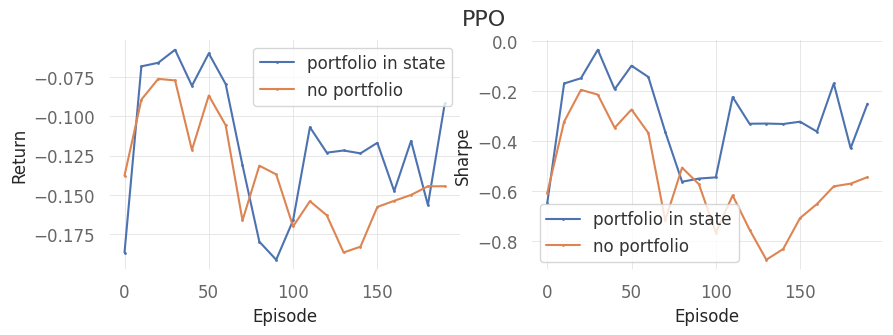

In [8]:
model_params = {'type':'PPO'}
# model_params = {'type':'A2C', 'lr':0.0007}

fig,axs = plt.subplots(1,2, figsize=(10,3))

for x in [1,0]:
    trainer = AgentTrainer(daily_prices, train_val_splits, 200, 10, 5, model_params, pfstate=x)
    results = trainer.train(len(train_val_splits)-1)

    for i in range(2):
        ks = np.arange(20) * 10
        avs = np.mean(results[i], axis=0)
        maxs = np.max(results[i], axis=0)
        mins = np.min(results[i], axis=0)

        axs[i].fill_between(ks, mins, maxs, alpha=0.1)
        if x:
            axs[i].plot(ks, avs, '-o', markersize=1, label='portfolio in state')
            print("Portfolio", "returns" if i == 0 else "sharpe", avs[-1])
        else:
            axs[i].plot(ks, avs, '-o', markersize=1, label='no portfolio')
            print("No Portfolio", "returns" if i == 0 else "sharpe", avs[-1])
        axs[i].legend()
        axs[i].set_xlabel('Episode', fontsize=12)
        if i == 0:
            axs[i].set_ylabel('Return', fontsize=12)
        else:
            axs[i].set_ylabel('Sharpe', fontsize=12)
plt.suptitle(model_params['type'], fontsize=16)

plt.savefig("./plots/hold_state/{}_curve_oracle.png".format(model_params['type']))

In [ ]:
print(results[0].shape)
print(np.mean(results[0],axis=0))